## Imports

In [1]:
import numpy as np
import pandas as pd

import gymnasium as gym

import torch
from transformers import LlamaForCausalLM, AutoTokenizer

from dicl import dicl

<module 'dicl.main.dicl' from '/home/abenechehab/dicl/src/dicl/main/dicl.py'>

## Load LLM model and tokenizer

* The tokenizers that are supported are those who assign a separate token to each number between 0 and 999. This includes Llama 3, Llama 3.1, and Llama 3.2 families of models.

In [44]:
llm_model = "meta-llama/Llama-3.1-8B"

tokenizer = AutoTokenizer.from_pretrained(
    llm_model,
    use_fast=False,
)
model = LlamaForCausalLM.from_pretrained(
    llm_model,
    device_map="auto",
    torch_dtype=torch.bfloat16,
)
model.eval()

Loading checkpoint shards: 100%|██████████| 4/4 [20:47<00:00, 311.92s/it]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
    )
    (n

## Load data

* Problem parameters

In [56]:
env_name = "HalfCheetah"
env = gym.make(env_name + "-v4")
n_actions = env.action_space.shape[0]
n_observations = env.observation_space.shape[0]
data_label = "expert"
data_path = f"data/D4RL_{env_name}_{data_label}.csv"
context_length = 300
rescale_factor = 7.0
up_shift = 1.5

* Pick DICL(s) or DICL(s,a) method through the number of features (choose n_observations for vICL)

In [ ]:
# ------- number of features = n_observations for DICL-(s) or vICL -------
# n_features = n_observations
# ------- number of features = n_observations+n_actions for DICL-(s,a) -------
n_features = n_observations + n_actions

* Sample an episode and extract in-context trajectory (n_timestamps, n_features)

In [57]:
# load some data to get a sample episode
X = pd.read_csv(data_path, index_col=0)
X = X.values.astype("float")

# find episodes beginnings
restart_index = n_observations + n_actions + 1  # restart column
restarts = X[:, restart_index]
episode_starts = np.where(restarts)[0]

# sample an episode and extract time series
episode = np.random.choice(episode_starts)
time_series = X[episode : episode + context_length, :n_features]

print(
    f"The in-context trajectory shape is (n_timestamps:{time_series.shape[0]}, "
    f"n_features:{time_series.shape[1]})"
)

The in-context trajectory shape is (n_timestamps:300, n_features:23)


## DICL

* Instantiate DICL
* choose the number of components for PCA (set to half here)
* for vICL n_components has to be equal to n_features

In [58]:
# ------- For DICL-PCA -------
DICL = dicl.DICL_PCA(
    n_features=n_features,
    n_components=int(n_features / 2),
    model=model,
    tokenizer=tokenizer,
    rescale_factor=rescale_factor,
    up_shift=up_shift,
)
# ------- For vICL -------
# DICL = dicl.vICL(
#     n_features=n_features,
#     n_components=n_features,
#     model=model,
#     tokenizer=tokenizer,
#     rescale_factor=rescale_factor,
#     up_shift=up_shift,
# )

* Fit disentangler (PCA here). This can be done using a bigger dataset than the in-context time series

In [59]:
DICL.fit_disentangler(X=time_series)

### Single-step prediction and visualization

In [60]:
mean, mode, lb, ub = DICL.predict_single_step(X=time_series)

# print metrics
burnin = 0
single_step_metrics = DICL.compute_metrics(burnin=burnin)
print(f"after burnin steps: {burnin}")
print(
    "average_agg_squared_error: "
    f"{single_step_metrics['average_agg_squared_error']:.3f}"
)
print(f"agg_ks: {single_step_metrics['agg_ks']}")

after burnin steps: 0
average_agg_squared_error: 12.838
agg_ks: 0.08542533081285444


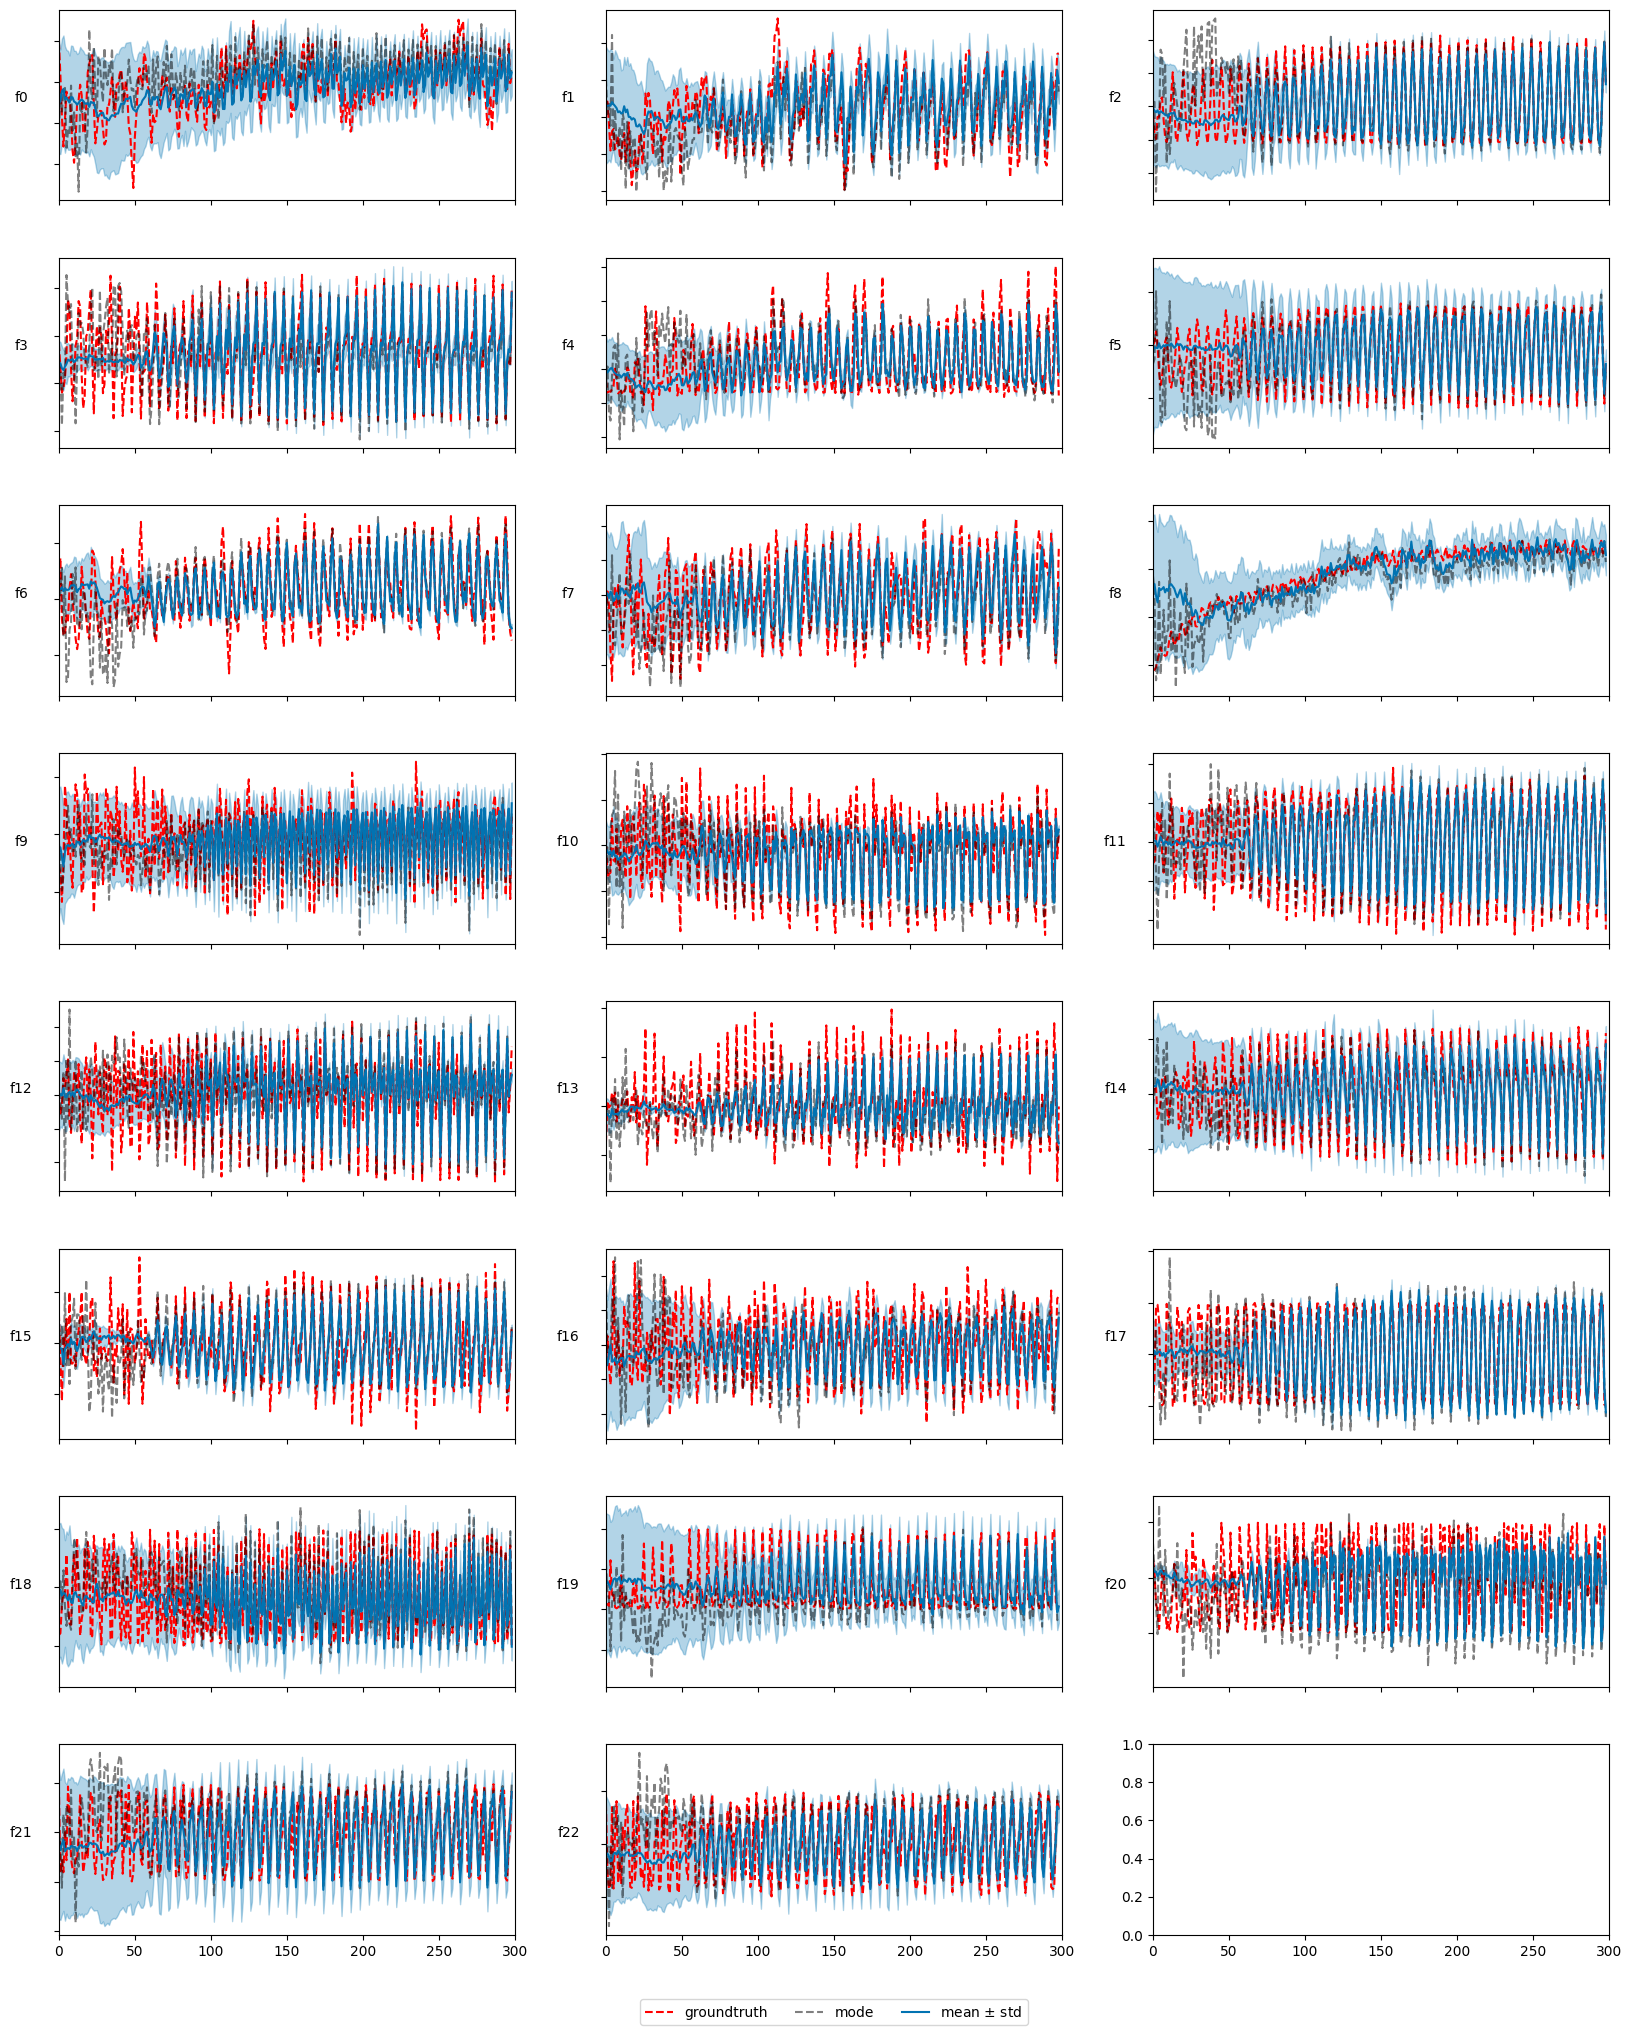

In [62]:
DICL.plot_single_step(xlim=[0, context_length])

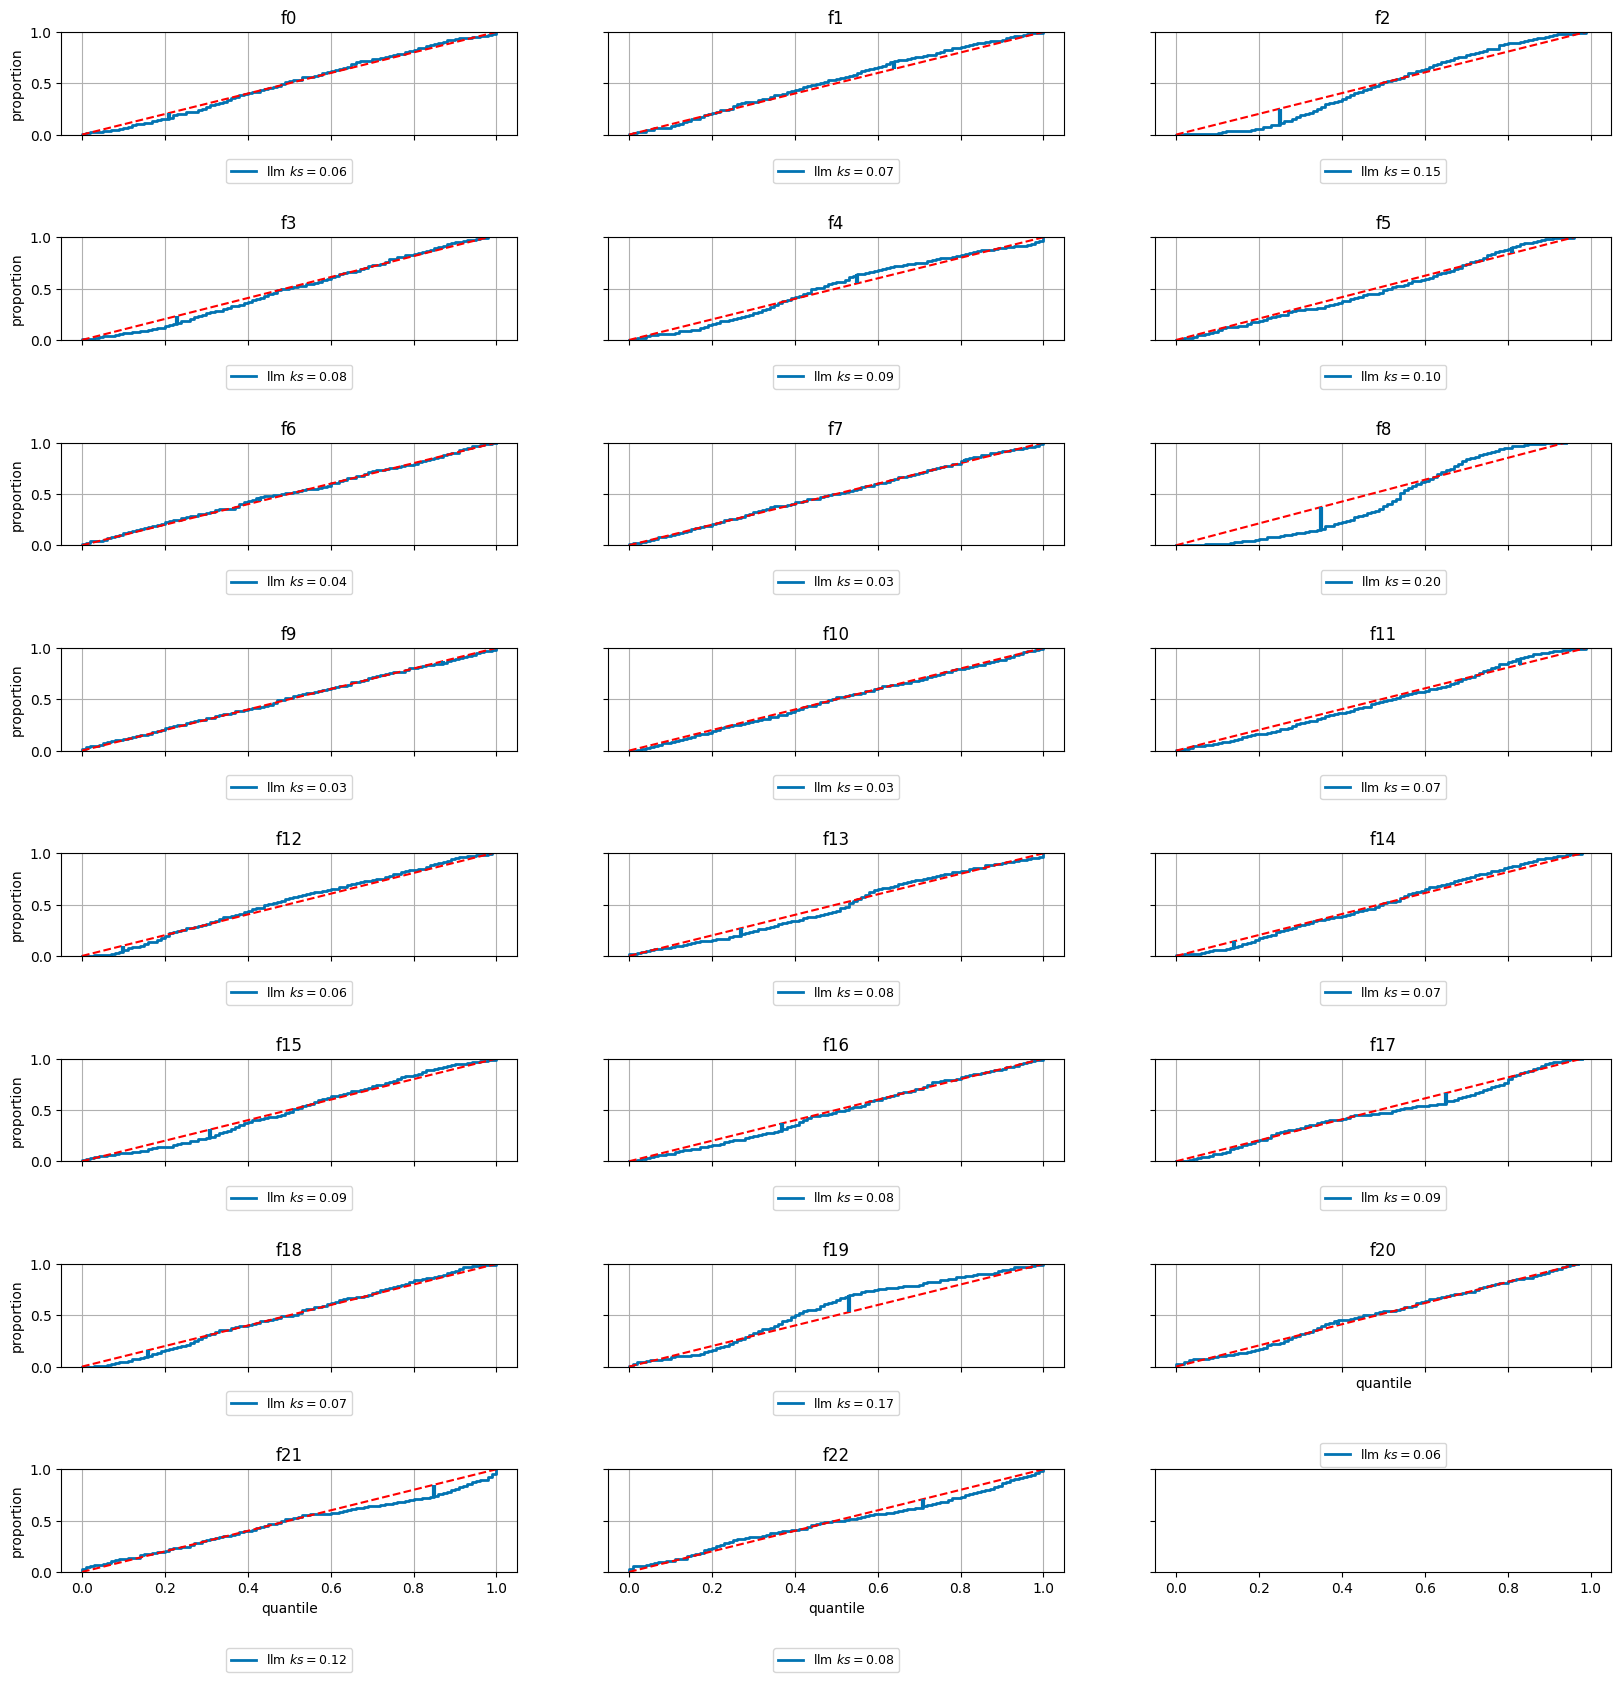

In [63]:
DICL.plot_calibration(burnin=0)

### Autoregressive multi-step prediction and visualization

In [64]:
prediction_horizon = 20
mean, mode, lb, ub = DICL.predict_multi_step(
    X=time_series,
    prediction_horizon=prediction_horizon,
    stochastic=True,
    if_true_mean_else_mode=True,
)

prediction_horizon: 100%|██████████| 20/20 [05:53<00:00, 17.70s/it]


In [65]:
# print metrics
burnin = context_length - prediction_horizon  # only keeps multi-step prediction
single_step_metrics = DICL.compute_metrics(burnin=burnin)
print(f"after burnin steps: {burnin}")
print(
    "average_agg_squared_error: "
    f"{single_step_metrics['average_agg_squared_error']:.3f}"
)
print(f"agg_ks: {single_step_metrics['agg_ks']}")

after burnin steps: 280
average_agg_squared_error: 10.421
agg_ks: 0.38434782608695645


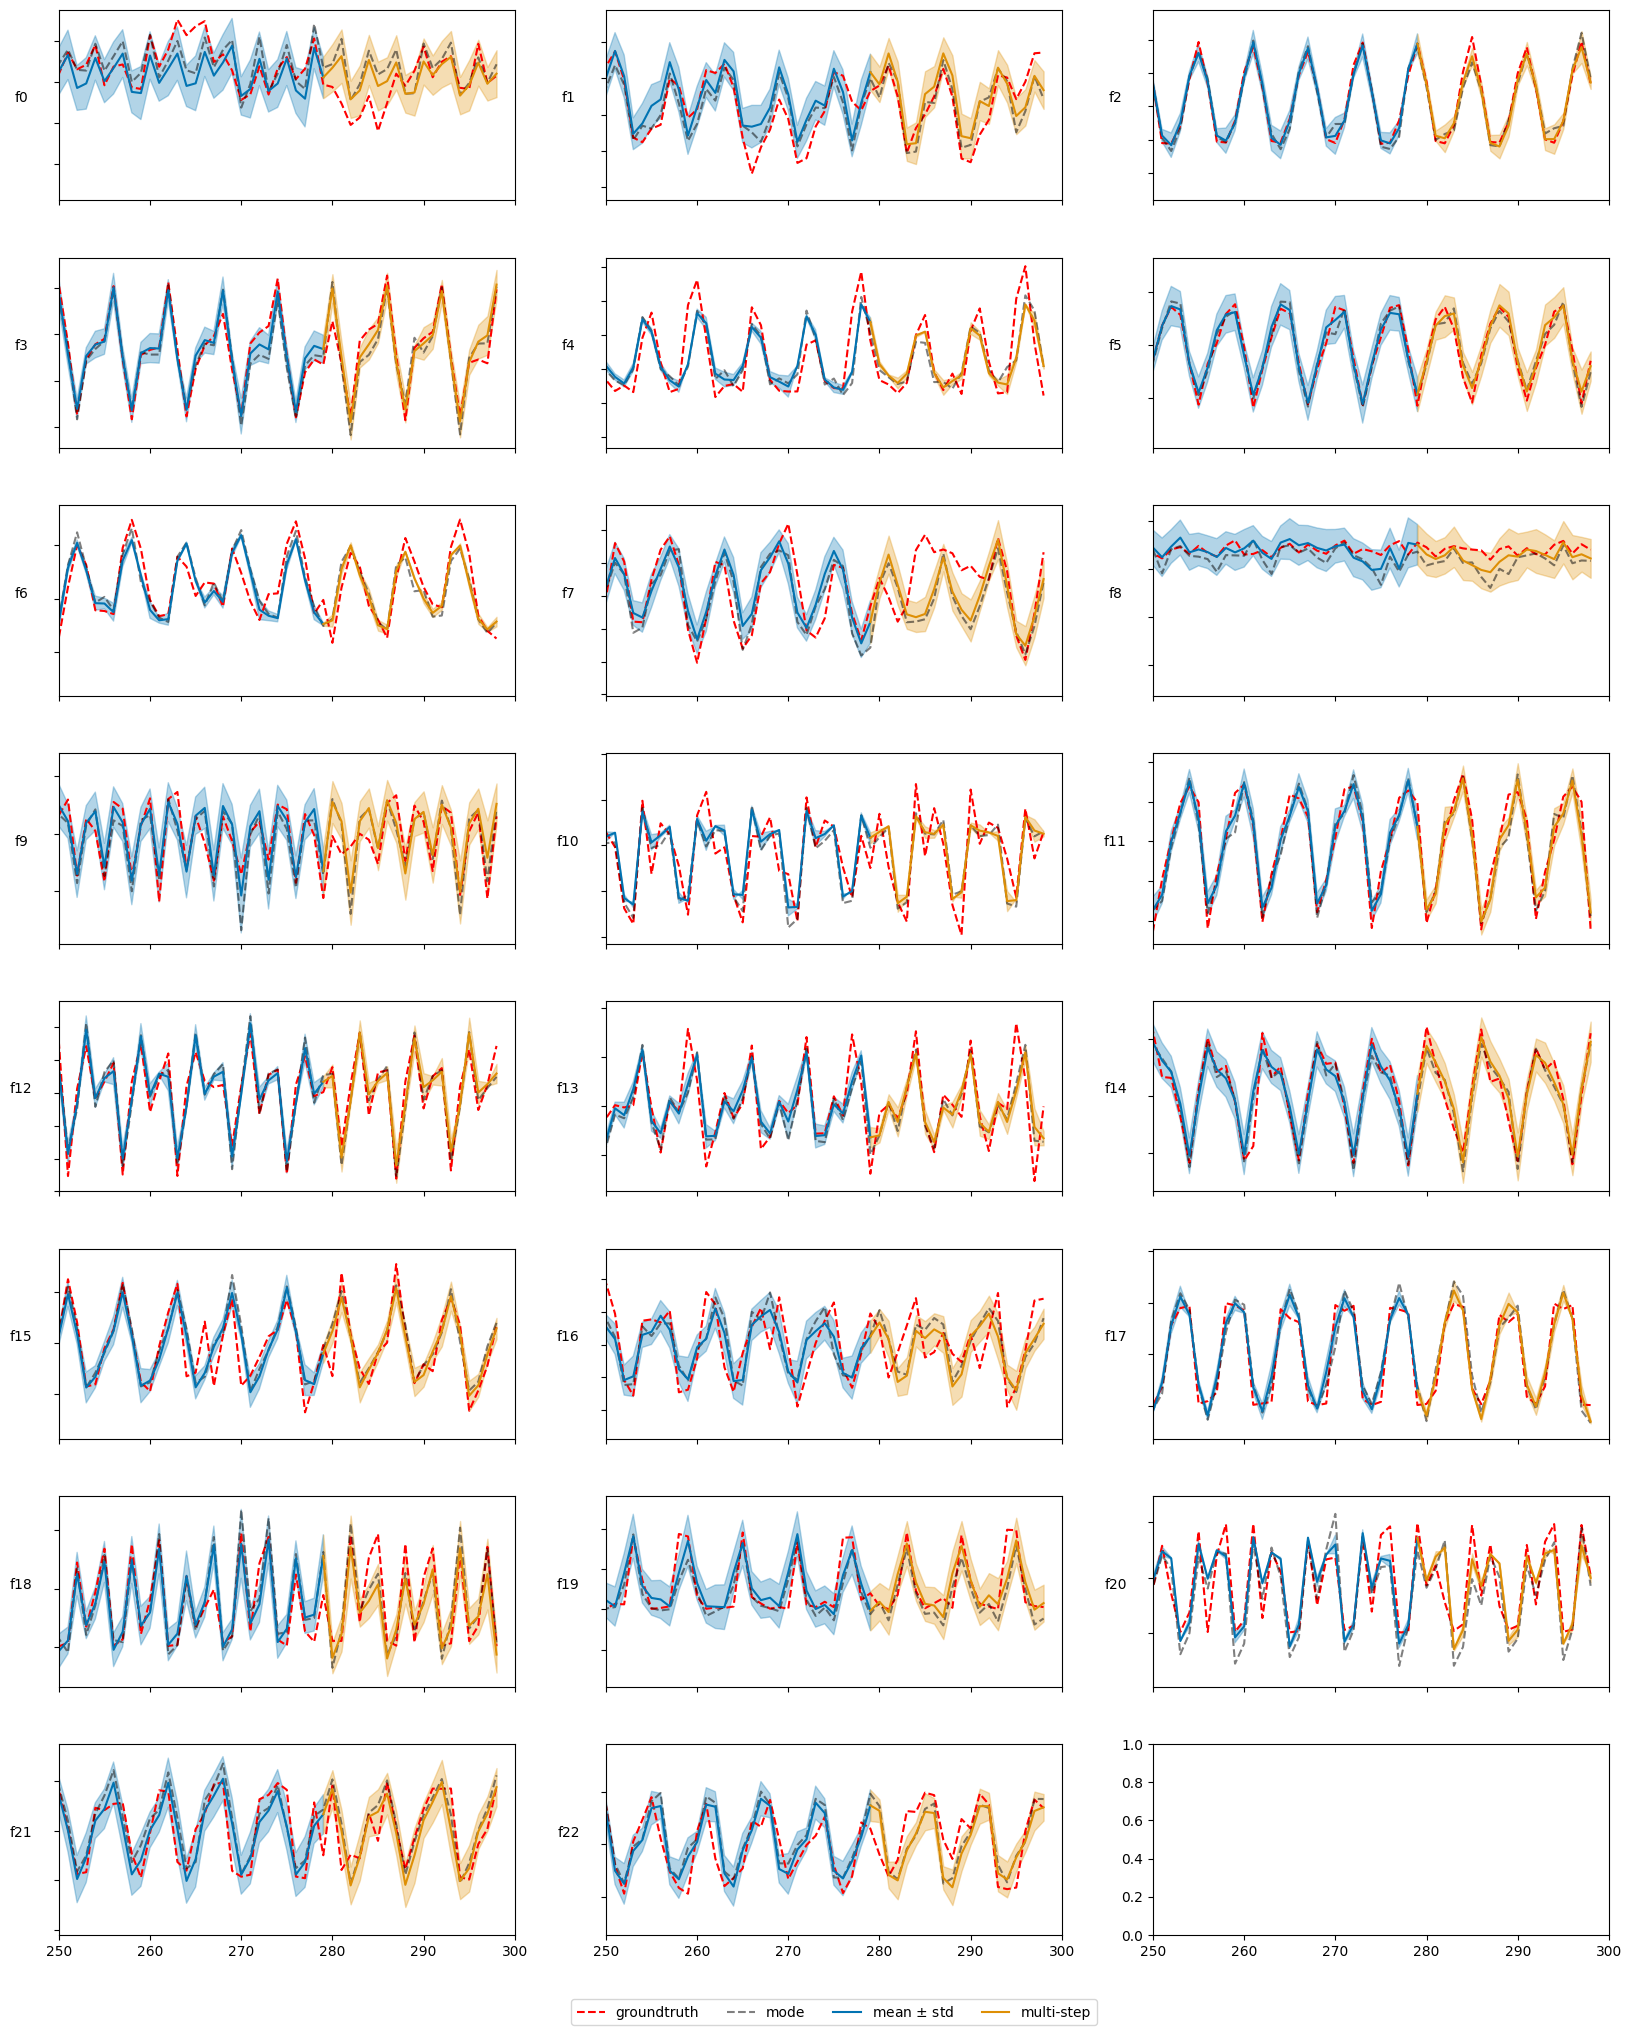

In [68]:
DICL.plot_multi_step(xlim=[context_length - 50, context_length])

For any questions, feel free to contact **Abdelhakim Benechehab** at [abdelhakim.benechehab@gmail.com](mailto:abdelhakim.benechehab@gmail.com).